## Load modules.

In [1]:
#Import module
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

import re

## Read gene count table

In [2]:
data=pd.read_csv('../diff-cancer/machine-classifer/transcript_mirna.txt',sep="\t")
label=pd.read_csv('../diff-cancer/machine-classifer/sample_classes.txt',sep="\t")

print(type(data))
print(data.head())
print(type(label))
print(label.head())

<class 'pandas.core.frame.DataFrame'>
                                             feature  Sample_1S3  Sample_1S6  \
0  hsa-let-7a-2-3p|miRNA|hsa-let-7a-2-3p|hsa-let-...           9          14   
1  hsa-let-7a-3p|miRNA|hsa-let-7a-3p|hsa-let-7a-3...         283         503   
2  hsa-let-7a-5p|miRNA|hsa-let-7a-5p|hsa-let-7a-5...        2460        6617   
3  hsa-let-7b-3p|miRNA|hsa-let-7b-3p|hsa-let-7b-3...         230         340   
4  hsa-let-7b-5p|miRNA|hsa-let-7b-5p|hsa-let-7b-5...       56569       55954   

   Sample_1S9  Sample_1S12  Sample_1S15  Sample_1S18  Sample_1S21  \
0           3            1            6            1            6   
1         214          153          451          165          435   
2        2140         1718         3872         1757         4559   
3         147          219          207          122          189   
4       51215        55669        23908        25192        32174   

   Sample_1S24  Sample_4S2     ...       Sample_4S16  Sample_4S19 

In [3]:
#data.iloc[0,0]
d1=data.loc[data['feature']=='hsa-let-7a-2-3p|miRNA|hsa-let-7a-2-3p|hsa-let-7a-2-3p|hsa-let-7a-2-3p|0|22']
d2=label.iloc[:,1].values
d2_unique=np.unique(d2)

#type(d2)
#print(d2)
print(d2_unique)

['Colorectal Cancer Stage 1' 'Colorectal Cancer Stage 2'
 'Colorectal Cancer Stage 3' 'Colorectal Cancer Stage 4' 'Healthy Control'
 'Pancreatic Cancer' 'Prostate Cancer']


## Normolize by sample with CPM

In [4]:
#get dataframe shape
shape=data.shape

#divide gene counts and gene name
data_without_gene=data.iloc[:,1:shape[1]-1]
data_name=data.iloc[:,0]

#
#data_without_gene
#Sum each columns.
data_without_gene_sum=data_without_gene.sum()

#Calculate scale factor with cpm.
data_without_gene_sum_scale=data_without_gene_sum/1000000
data_without_gene_sum_scale=data_without_gene_sum_scale.values
data_without_gene_sum_scale

#Normolization gene counts with scale factor
data_without_gene_norm=data_without_gene/data_without_gene_sum_scale

#merge data frame
data_without_gene_norm_complete=pd.concat([data_name,data_without_gene_norm],axis=1)
data_without_gene_norm_complete.head()


,feature,Sample_1S3,Sample_1S6,Sample_1S9,Sample_1S12,Sample_1S15,Sample_1S18,Sample_1S21,Sample_1S24,Sample_4S2,...,Sample_4S13,Sample_4S16,Sample_4S19,Sample_4S22,Sample_4S25,Sample_N49,Sample_Pan05,Sample_Pan06,Sample_PC6,Sample_PC12
0,hsa-let-7a-2-3p|miRNA|hsa-let-7a-2-3p|hsa-let-...,3.345375,5.742650,1.318290,0.335680,3.976786,0.592745,3.334663,2.801259,5.571423,...,2.968337,4.713108,1.153527,2.501790,2.144001,3.977516,0.984505,1.042936,2.230764,4.203083
1,hsa-let-7a-3p|miRNA|hsa-let-7a-3p|hsa-let-7a-3...,105.193472,206.325201,94.038033,51.358965,298.921761,97.802931,241.763103,197.488742,262.254842,...,325.032874,191.928227,71.134175,93.400153,293.728070,302.652822,183.117907,173.127305,93.692070,226.616234
2,hsa-let-7a-5p|miRNA|hsa-let-7a-5p|hsa-let-7a-5...,914.402622,2714.222369,940.380327,576.697397,2566.352677,1041.453031,2533.788478,2285.126822,2577.181123,...,2377.143015,3097.035560,697.883931,1047.416006,2701.869440,2717.005147,1515.153007,1519.557128,760.371696,2044.099449
3,hsa-let-7b-3p|miRNA|hsa-let-7b-3p|hsa-let-7b-3...,85.492928,139.464350,64.596219,73.513813,137.199123,72.314895,105.041900,97.343741,133.316195,...,129.617371,131.967021,66.904575,115.916262,132.070431,132.704404,122.078605,133.495753,84.450335,138.351488
4,hsa-let-7b-5p|miRNA|hsa-let-7b-5p|hsa-let-7b-5...,21027.171511,22951.730158,22505.410483,18686.942604,15846.167306,14932.432993,17881.577207,20568.592497,21228.713682,...,14704.645546,16722.892298,14487.532102,17974.108977,16100.586213,22390.161795,16191.167219,16844.452417,18970.732063,20768.484722


## Label and Counts

In [5]:
# Get label class.
label_class=label['label'].unique()
##print(label_class)

#Get healty class
label_healty=label.loc[label['label']=='Healthy Control']
healty=label_healty.iloc[:,0].values
healty2=np.append(['feature'],healty)
##print(healty)

#Get Colorectal cancer
label_colorectal_boolen=(label['label']=='Colorectal Cancer Stage 1' ) | (label['label']=='Colorectal Cancer Stage 2')| (label['label']=='Colorectal Cancer Stage 3')| (label['label']=='Colorectal Cancer Stage 4')
label_colorectal=label.loc[label_colorectal_boolen]
##print(label_colorectal)
colorectal=label_colorectal.iloc[:,0].values
colorectal2=np.append(['feature'],colorectal)
#print(colorectal)

#Get Prostate
label_prostate=label.loc[label['label']=='Prostate Cancer']
##print(label_prostate)
prostate=label_prostate.iloc[:,0].values
prostate2=np.append(['feature'],prostate)

#Get Pancreatic
label_pancreatic=label.loc[label['label']=='Pancreatic Cancer']
##print(label_pancreatic)
##type(label_pancreatic)
pancreatic=label_pancreatic.iloc[:,0].values
pancreatic2=np.append(['feature'],pancreatic)

type(pancreatic2)
print(pancreatic2)


['feature' 'Sample_Pan01' 'Sample_Pan02' 'Sample_Pan03' 'Sample_Pan04'
 'Sample_Pan05' 'Sample_Pan06']


## Generate arrays: expression and label.

In [6]:
healty_count=data_without_gene_norm_complete[healty2]
colorectal_count=data_without_gene_norm_complete[colorectal2]
##
## There is not have Sample_PC26, so remove it.
prostate_count=data_without_gene_norm_complete[prostate2[0:36]]
pancreatic_count=data_without_gene_norm_complete[pancreatic2]

In [7]:
print(pancreatic_count)

                                                feature   Sample_Pan01  \
0     hsa-let-7a-2-3p|miRNA|hsa-let-7a-2-3p|hsa-let-...       3.231474   
1     hsa-let-7a-3p|miRNA|hsa-let-7a-3p|hsa-let-7a-3...     204.660000   
2     hsa-let-7a-5p|miRNA|hsa-let-7a-5p|hsa-let-7a-5...    1868.868952   
3     hsa-let-7b-3p|miRNA|hsa-let-7b-3p|hsa-let-7b-3...     145.416316   
4     hsa-let-7b-5p|miRNA|hsa-let-7b-5p|hsa-let-7b-5...   15746.971301   
5     hsa-let-7c-3p|miRNA|hsa-let-7c-3p|hsa-let-7c-3...      19.388842   
6     hsa-let-7c-5p|miRNA|hsa-let-7c-5p|hsa-let-7c-5...    1509.098214   
7     hsa-let-7d-3p|miRNA|hsa-let-7d-3p|hsa-let-7d-3...    1090.083792   
8     hsa-let-7d-5p|miRNA|hsa-let-7d-5p|hsa-let-7d-5...     618.288633   
9     hsa-let-7e-3p|miRNA|hsa-let-7e-3p|hsa-let-7e-3...      65.706632   
10    hsa-let-7e-5p|miRNA|hsa-let-7e-5p|hsa-let-7e-5...     310.221474   
11    hsa-let-7f-1-3p|miRNA|hsa-let-7f-1-3p|hsa-let-...      33.391895   
12    hsa-let-7f-2-3p|miRNA|hsa-let-7f

## Select one gene to plot auc.

In [8]:
gene_name='hsa-let-7a-3p|miRNA|hsa-let-7a-3p|hsa-let-7a-3p|hsa-let-7a-3p|0|21'
roc_calcualte(gene_name)

NameError: name 'roc_calcualte' is not defined

In [9]:
def roc_calcualte_plot(gene_name):
    #Select biomarker by gene name.
    global healty_count
    global colorectal_count
    global control_label
    global cancer_label
    
    control=healty_count.loc[healty_count['feature']==gene_name]
    cancer=colorectal_count.loc[colorectal_count['feature']==gene_name]

    #Remove the name
    control2=control.iloc[:,1:control.shape[1]].values
    cancer2=cancer.iloc[:,1:cancer.shape[1]].values
    Expression2=np.append(control2[0],cancer2[0])

    #set class label
    control_label=np.repeat(0,control2[0].shape)
    cancer_label=np.repeat(1,cancer2[0].shape)

    #merge label
    Label2=np.append(control_label,cancer_label)

    #input data
    Expression=np.asarray(Expression2)
    Label=np.asarray(Label2)

    # set dictory
    Fpr = dict()
    Tpr = dict()
    Roc_auc = dict()

    #calculate FPR, TPR and ROC
    Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
    Roc_auc[0] = auc(Fpr[0], Tpr[0])

    #Calculate micro-FPR, micro-TPR and micro-AUC
    Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
    Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])

    # Compute macro-average ROC curve and ROC area


    # First aggregate all false positive rates
    All_Fpr = np.unique(Fpr[0])


    # Then interpolate all ROC curves at this points
    mean_Tpr = np.zeros_like(All_Fpr)
    mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])


    # Finally average it and compute AUC

    Fpr["macro"] = All_Fpr
    Tpr["macro"] = mean_Tpr
    Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])

    if(Roc_auc[0]<0.5):
        control_label=np.repeat(1,control2[0].shape)
        cancer_label=np.repeat(0,cancer2[0].shape)
        Label2=np.append(control_label,cancer_label)
        Label=np.asarray(Label2)
        # set dictory
        Fpr = dict()
        Tpr = dict()
        Roc_auc = dict()
        #calculate FPR, TPR and ROC
        Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
        Roc_auc[0] = auc(Fpr[0], Tpr[0])
        #Calculate micro-FPR, micro-TPR and micro-AUC
        Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
        Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        All_Fpr = np.unique(Fpr[0])
        # Then interpolate all ROC curves at this points
        mean_Tpr = np.zeros_like(All_Fpr)
        mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])
        # Finally average it and compute AUC
        Fpr["macro"] = All_Fpr
        Tpr["macro"] = mean_Tpr
        Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])
        
    names_plt=gene_name.split('|')

    # Plot all ROC curves
    color='cornflowerblue'
    lw=2
    plt.figure(figsize=(8, 8))
    plt.plot(Fpr["micro"], Tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(Roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(Fpr["macro"], Tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(Roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


    plt.plot(Fpr[0], Tpr[0], color=color, lw=lw,
        label='ROC curve of class (area = {1:0.2f})'
        ''.format(0, Roc_auc[0]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(names_plt[0]+' Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
def roc_calcualte(gene_name):
    #Select biomarker by gene name.
    control=healty_count.loc[healty_count['feature']==gene_name]
    cancer=colorectal_count.loc[colorectal_count['feature']==gene_name]

    #Remove the name
    control2=control.iloc[:,1:control.shape[1]].values
    cancer2=cancer.iloc[:,1:cancer.shape[1]].values
    Expression2=np.append(control2[0],cancer2[0])

    #set class label
    control_label=np.repeat(0,control2[0].shape)
    cancer_label=np.repeat(1,cancer2[0].shape)

    #merge label
    Label2=np.append(control_label,cancer_label)

    #input data
    Expression=np.asarray(Expression2)
    Label=np.asarray(Label2)

    # set dictory
    Fpr = dict()
    Tpr = dict()
    Roc_auc = dict()

    #calculate FPR, TPR and ROC
    Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
    Roc_auc[0] = auc(Fpr[0], Tpr[0])

    #Calculate micro-FPR, micro-TPR and micro-AUC
    Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
    Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])

    # Compute macro-average ROC curve and ROC area


    # First aggregate all false positive rates
    All_Fpr = np.unique(Fpr[0])


    # Then interpolate all ROC curves at this points
    mean_Tpr = np.zeros_like(All_Fpr)
    mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])


    # Finally average it and compute AUC

    Fpr["macro"] = All_Fpr
    Tpr["macro"] = mean_Tpr
    Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])

    if(Roc_auc[0]<0.5):
        control_label=np.repeat(1,control2[0].shape)
        cancer_label=np.repeat(0,cancer2[0].shape)
        Label2=np.append(control_label,cancer_label)
        Label=np.asarray(Label2)
        # set dictory
        Fpr = dict()
        Tpr = dict()
        Roc_auc = dict()
        #calculate FPR, TPR and ROC
        Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
        Roc_auc[0] = auc(Fpr[0], Tpr[0])
        #Calculate micro-FPR, micro-TPR and micro-AUC
        Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
        Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        All_Fpr = np.unique(Fpr[0])
        # Then interpolate all ROC curves at this points
        mean_Tpr = np.zeros_like(All_Fpr)
        mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])
        # Finally average it and compute AUC
        Fpr["macro"] = All_Fpr
        Tpr["macro"] = mean_Tpr
        Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])
    return Roc_auc[0]

In [11]:
def roc_calcualte_all(gene_name):
    #Select biomarker by gene name.
    control=healty_count.loc[healty_count['feature']==gene_name]
    cancer=colorectal_count.loc[colorectal_count['feature']==gene_name]

    #Remove the name
    control2=control.iloc[:,1:control.shape[1]].values
    cancer2=cancer.iloc[:,1:cancer.shape[1]].values
    Expression2=np.append(control2[0],cancer2[0])

    #set class label
    control_label=np.repeat(0,control2[0].shape)
    cancer_label=np.repeat(1,cancer2[0].shape)

    #merge label
    Label2=np.append(control_label,cancer_label)

    #input data
    Expression=np.asarray(Expression2)
    Label=np.asarray(Label2)

    # set dictory
    Fpr = dict()
    Tpr = dict()
    Roc_auc = dict()

    #calculate FPR, TPR and ROC
    Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
    Roc_auc[0] = auc(Fpr[0], Tpr[0])

    #Calculate micro-FPR, micro-TPR and micro-AUC
    Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
    Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])

    # Compute macro-average ROC curve and ROC area


    # First aggregate all false positive rates
    All_Fpr = np.unique(Fpr[0])


    # Then interpolate all ROC curves at this points
    mean_Tpr = np.zeros_like(All_Fpr)
    mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])


    # Finally average it and compute AUC

    Fpr["macro"] = All_Fpr
    Tpr["macro"] = mean_Tpr
    Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])

    if(Roc_auc[0]<0.5):
        control_label=np.repeat(1,control2[0].shape)
        cancer_label=np.repeat(0,cancer2[0].shape)
        Label2=np.append(control_label,cancer_label)
        Label=np.asarray(Label2)
        # set dictory
        Fpr = dict()
        Tpr = dict()
        Roc_auc = dict()
        #calculate FPR, TPR and ROC
        Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
        Roc_auc[0] = auc(Fpr[0], Tpr[0])
        #Calculate micro-FPR, micro-TPR and micro-AUC
        Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
        Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        All_Fpr = np.unique(Fpr[0])
        # Then interpolate all ROC curves at this points
        mean_Tpr = np.zeros_like(All_Fpr)
        mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])
        # Finally average it and compute AUC
        Fpr["macro"] = All_Fpr
        Tpr["macro"] = mean_Tpr
        Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])
    return [ [Roc_auc[0], Fpr[0], Tpr[0]], [ Roc_auc["micro"], Fpr["micro"], Tpr["micro"]],[Roc_auc["macro"],Fpr["macro"],Tpr["macro"]] ]


In [41]:
names=data_without_gene_norm_complete.iloc[:,0]
print(names)

0       hsa-let-7a-2-3p|miRNA|hsa-let-7a-2-3p|hsa-let-...
1       hsa-let-7a-3p|miRNA|hsa-let-7a-3p|hsa-let-7a-3...
2       hsa-let-7a-5p|miRNA|hsa-let-7a-5p|hsa-let-7a-5...
3       hsa-let-7b-3p|miRNA|hsa-let-7b-3p|hsa-let-7b-3...
4       hsa-let-7b-5p|miRNA|hsa-let-7b-5p|hsa-let-7b-5...
5       hsa-let-7c-3p|miRNA|hsa-let-7c-3p|hsa-let-7c-3...
6       hsa-let-7c-5p|miRNA|hsa-let-7c-5p|hsa-let-7c-5...
7       hsa-let-7d-3p|miRNA|hsa-let-7d-3p|hsa-let-7d-3...
8       hsa-let-7d-5p|miRNA|hsa-let-7d-5p|hsa-let-7d-5...
9       hsa-let-7e-3p|miRNA|hsa-let-7e-3p|hsa-let-7e-3...
10      hsa-let-7e-5p|miRNA|hsa-let-7e-5p|hsa-let-7e-5...
11      hsa-let-7f-1-3p|miRNA|hsa-let-7f-1-3p|hsa-let-...
12      hsa-let-7f-2-3p|miRNA|hsa-let-7f-2-3p|hsa-let-...
13      hsa-let-7f-5p|miRNA|hsa-let-7f-5p|hsa-let-7f-5...
14      hsa-let-7g-3p|miRNA|hsa-let-7g-3p|hsa-let-7g-3...
15      hsa-let-7g-5p|miRNA|hsa-let-7g-5p|hsa-let-7g-5...
16      hsa-let-7i-3p|miRNA|hsa-let-7i-3p|hsa-let-7i-3...
17      hsa-le

In [13]:

values={}

for x in names:
    #print(x)
    value=roc_calcualte(x)
    values[x]=value
        

In [42]:
out=open('roc-data/crc-vs-health.txt','w')
out.write("data_source\tclassification\tname\tauc\tfpr\ttpr\tmicro-auc\tmicro-fpr\tmicor-tpr\tmacro-acu\tmacro-fpr\tmacro-tpr\n")
for name in names:
    string=roc_calcualte_all(name)
    array1=name.split('|')
    name=array1[0]
    name=name.replace('hsa-','')
    variable1=np.array2string(string[0][0]).replace('\n','')
    variable1=re.sub('\s+',",",variable1)
    variable1=re.sub('1.,]',"1]",variable1)
    variable1=re.sub('\[0.,','[0,',variable1)
    variable1=re.sub(',0.,',',0,',variable1)
    variable1=re.sub(',1.,',',1,',variable1)
    
    variable2=np.array2string(string[0][1]).replace('\n','')
    variable2=re.sub('\s+',",",variable2)
    variable2=re.sub('1.,]',"1]",variable2)
    variable2=re.sub('\[0.,','[0,',variable2)
    variable2=re.sub(',0.,',',0,',variable2)
    variable2=re.sub(',1.,',',1,',variable2)
    
    variable3=np.array2string(string[0][2]).replace('\n','')
    variable3=re.sub('\s+',",",variable3)
    variable3=re.sub('1.,]',"1]",variable3)
    variable3=re.sub('\[0.,','[0,',variable3)
    variable3=re.sub(',0.,',',0,',variable3)
    variable3=re.sub(',1.,',',1,',variable3)
    
    variable4=np.array2string(string[1][0]).replace('\n','')
    variable4=re.sub('\s+',",",variable4)
    variable4=re.sub('1.,]',"1]",variable4)
    variable4=re.sub('\[0.,','[0,',variable4)
    variable4=re.sub(',0.,',',0,',variable4)
    variable4=re.sub(',1.,',',1,',variable4)
    
    variable5=np.array2string(string[1][1]).replace('\n','')
    variable5=re.sub('\s+',",",variable5)
    variable5=re.sub('1.,]',"1]",variable5)
    variable5=re.sub('\[0.,','[0,',variable5)
    variable5=re.sub(',0.,',',0,',variable5)
    variable5=re.sub(',1.,',',1,',variable5)
    
    variable6=np.array2string(string[1][2]).replace('\n','')
    variable6=re.sub('\s+',",",variable6)
    variable6=re.sub('1.,]',"1]",variable6)
    variable6=re.sub('\[0.,','[0,',variable6)
    variable6=re.sub(',0.,',',0,',variable6)
    variable6=re.sub(',1.,',',1,',variable6)
    
    variable7=np.array2string(string[2][0]).replace('\n','')
    variable7=re.sub('\s+',",",variable7)
    variable7=re.sub('1.,]',"1]",variable7)
    variable7=re.sub('\[0.,','[0,',variable7)
    variable7=re.sub(',0.,',',0,',variable7)
    variable7=re.sub(',1.,',',1,',variable7)
    
    variable8=np.array2string(string[2][1]).replace('\n','')
    variable8=re.sub('\s+',",",variable8)
    variable8=re.sub('1.,]',"1]",variable8)
    variable8=re.sub('\[0.,','[0,',variable8)
    variable8=re.sub(',0.,',',0,',variable8)
    variable8=re.sub(',1.,',',1,',variable8)
    
    variable9=np.array2string(string[2][2]).replace('\n','')
    variable9=re.sub('\s+',",",variable9)
    variable9=re.sub('1.,]',"1]",variable9)
    variable9=re.sub('\[0.,','[0,',variable9)
    variable9=re.sub(',0.,',',0,',variable9)
    variable9=re.sub(',1.,',',1,',variable9)
    out.write("26786760\tColorectal-Healthy\t"+str(name)+"\t"+variable1+"\t"+variable2+"\t"+variable3+"\t"+variable4+"\t"+variable5+"\t"+variable6+"\t"+variable7+"\t"+variable8+"\t"+variable9+"\n")

    
    
    


In [48]:
string='[0.,0.,0.,0.02,0.02,0.07,0.07,'
string=re.sub(',0.,',',0,',string,count=0)
string=re.sub(',0.02,',',0.03,',string,count=0)
print(string)


[0.,0,0.,0.03,0.02,0.07,0.07,


In [15]:
values_sorted=sorted(values.items(), key=lambda x: x[1],reverse=True)
values_table=pd.DataFrame.from_dict(values_sorted)

In [40]:
print(values_table)
values_table.to_csv('healty_vs_CRC.csv',  encoding='utf-8')

                                                      0       1
0     hsa-miR-125a-5p|miRNA|hsa-miR-125a-5p|hsa-miR-...  0.7324
1     hsa-miR-1343-3p|miRNA|hsa-miR-1343-3p|hsa-miR-...  0.7312
2     hsa-miR-212-5p|miRNA|hsa-miR-212-5p|hsa-miR-21...  0.6902
3     hsa-miR-149-5p|miRNA|hsa-miR-149-5p|hsa-miR-14...  0.6830
4     hsa-miR-543|miRNA|hsa-miR-543|hsa-miR-543|hsa-...  0.6794
5     hsa-miR-128-3p|miRNA|hsa-miR-128-3p|hsa-miR-12...  0.6776
6     hsa-miR-935|miRNA|hsa-miR-935|hsa-miR-935|hsa-...  0.6762
7     hsa-miR-181b-2-3p|miRNA|hsa-miR-181b-2-3p|hsa-...  0.6746
8     hsa-miR-191-3p|miRNA|hsa-miR-191-3p|hsa-miR-19...  0.6720
9     hsa-miR-455-5p|miRNA|hsa-miR-455-5p|hsa-miR-45...  0.6720
10    hsa-miR-346|miRNA|hsa-miR-346|hsa-miR-346|hsa-...  0.6700
11    hsa-miR-30a-3p|miRNA|hsa-miR-30a-3p|hsa-miR-30...  0.6658
12    hsa-miR-411-3p|miRNA|hsa-miR-411-3p|hsa-miR-41...  0.6652
13    hsa-miR-28-3p|miRNA|hsa-miR-28-3p|hsa-miR-28-3...  0.6642
14    hsa-miR-744-3p|miRNA|hsa-miR-744-3

In [17]:
#print(values_table.iloc[1:11,])
for i in range(10):
    print(values_table.iloc[i,0],values_table.iloc[i,1])

hsa-miR-125a-5p|miRNA|hsa-miR-125a-5p|hsa-miR-125a-5p|hsa-miR-125a-5p|0|24 0.7323999999999999
hsa-miR-1343-3p|miRNA|hsa-miR-1343-3p|hsa-miR-1343-3p|hsa-miR-1343-3p|0|22 0.7312
hsa-miR-212-5p|miRNA|hsa-miR-212-5p|hsa-miR-212-5p|hsa-miR-212-5p|0|23 0.6902
hsa-miR-149-5p|miRNA|hsa-miR-149-5p|hsa-miR-149-5p|hsa-miR-149-5p|0|23 0.683
hsa-miR-543|miRNA|hsa-miR-543|hsa-miR-543|hsa-miR-543|0|22 0.6794
hsa-miR-128-3p|miRNA|hsa-miR-128-3p|hsa-miR-128-3p|hsa-miR-128-3p|0|21 0.6776
hsa-miR-935|miRNA|hsa-miR-935|hsa-miR-935|hsa-miR-935|0|23 0.6761999999999999
hsa-miR-181b-2-3p|miRNA|hsa-miR-181b-2-3p|hsa-miR-181b-2-3p|hsa-miR-181b-2-3p|0|20 0.6746
hsa-miR-191-3p|miRNA|hsa-miR-191-3p|hsa-miR-191-3p|hsa-miR-191-3p|0|22 0.672
hsa-miR-455-5p|miRNA|hsa-miR-455-5p|hsa-miR-455-5p|hsa-miR-455-5p|0|22 0.6719999999999999


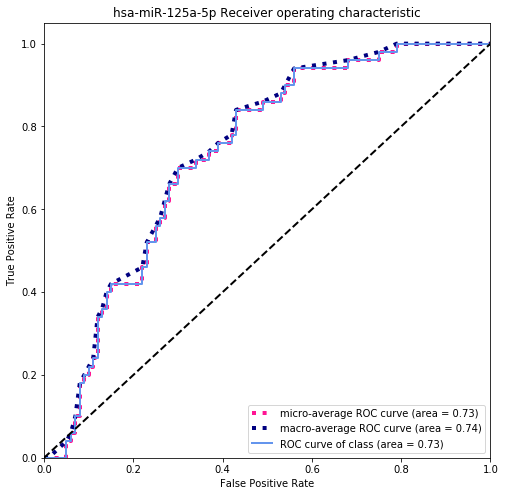

In [602]:
roc_calcualte_plot('hsa-miR-125a-5p|miRNA|hsa-miR-125a-5p|hsa-miR-125a-5p|hsa-miR-125a-5p|0|24')

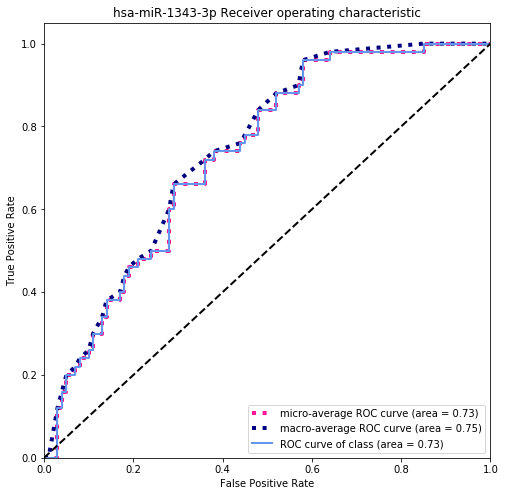

In [603]:
roc_calcualte_plot('hsa-miR-1343-3p|miRNA|hsa-miR-1343-3p|hsa-miR-1343-3p|hsa-miR-1343-3p|0|22')

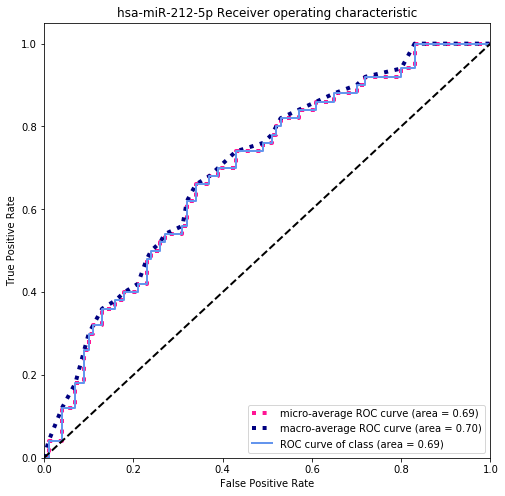

In [604]:
roc_calcualte_plot('hsa-miR-212-5p|miRNA|hsa-miR-212-5p|hsa-miR-212-5p|hsa-miR-212-5p|0|23')

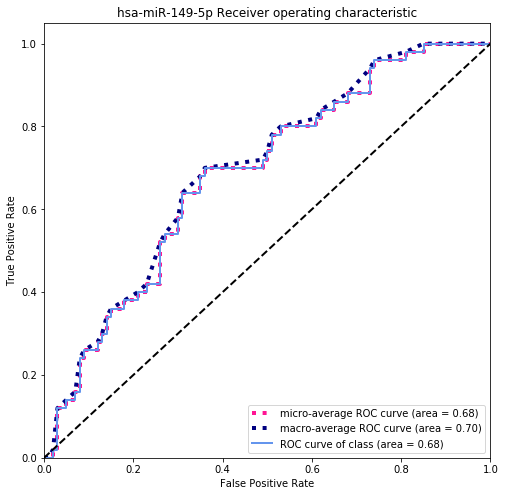

In [605]:
roc_calcualte_plot('hsa-miR-149-5p|miRNA|hsa-miR-149-5p|hsa-miR-149-5p|hsa-miR-149-5p|0|23')

## Read biomaker file

In [559]:
biomarker=pd.read_table('tmp-data/biomaker-id-CRC-0219.txt',sep="\t")
biomarker_name=biomarker.iloc[:,2].values
#print(biomarker_name)
biomarker_name_array=[]
for i in biomarker_name:
    array=i.split(',')
    for j in array:
        biomarker_name_array.append(j)
        
#print(biomarker_name_array)  

### select biomaker 

In [567]:
#print (values_table)
biomarker_auc=values_table.loc[values_table[0].isin(biomarker_name_array)]
biomarker_auc_values=biomarker_auc.iloc[:,1].values
all_auc_values=values_table.iloc[:,1].values

print(biomarker_auc_values,all_auc_values)

[0.6284 0.6226 0.6202 0.6188 0.6148 0.6132 0.611  0.6094 0.6078 0.601
 0.6008 0.5974 0.596  0.5958 0.5942 0.5936 0.5906 0.5896 0.588  0.5842
 0.5818 0.5816 0.58   0.5798 0.5774 0.5756 0.5752 0.5732 0.5728 0.5726
 0.5712 0.5708 0.568  0.5678 0.5652 0.565  0.565  0.5584 0.5556 0.5548
 0.5512 0.55   0.5482 0.5446 0.5428 0.5392 0.539  0.5334 0.5284 0.5262
 0.5234 0.5234 0.523  0.519  0.5184 0.518  0.516  0.5134 0.5112 0.5102
 0.5096 0.5096 0.5086 0.5074 0.5024 0.5004] [0.7324 0.7312 0.6902 ... 0.5    0.5    0.5   ]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f18cf3da160>,
 'caps': [<matplotlib.lines.Line2D at 0x7f18cf59e588>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f18cf3da8d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f18cf59ee48>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f18cf5cf160>,
 'means': []}

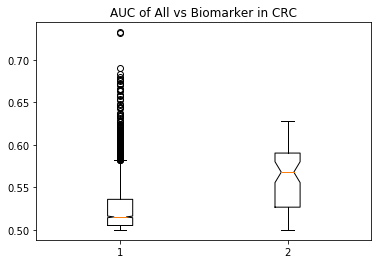

In [574]:
data = [all_auc_values,biomarker_auc_values]

fig2, ax2 = plt.subplots()
ax2.set_title('AUC of All vs Biomarker in CRC')
ax2.boxplot(data, notch=True)
#plt.plot(all_auc_values,biomarker_auc_values, linewidth=1, color='k')